# Import Libraries


In [ ]:
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

Upload pokemon zipped file on colab

In [1]:
from google.colab import files
uploaded = files.upload()

Saving archive (2).zip to archive (2).zip


Unzip file in colab

In [4]:
!unzip file.zip

Archive:  file.zip
  inflating: pokemon/pokemon/1.png   
  inflating: pokemon/pokemon/10.png  
  inflating: pokemon/pokemon/100.png  
  inflating: pokemon/pokemon/101.png  
  inflating: pokemon/pokemon/102.png  
  inflating: pokemon/pokemon/103.png  
  inflating: pokemon/pokemon/104.png  
  inflating: pokemon/pokemon/105.png  
  inflating: pokemon/pokemon/106.png  
  inflating: pokemon/pokemon/107.png  
  inflating: pokemon/pokemon/108.png  
  inflating: pokemon/pokemon/109.png  
  inflating: pokemon/pokemon/11.png  
  inflating: pokemon/pokemon/110.png  
  inflating: pokemon/pokemon/111.png  
  inflating: pokemon/pokemon/112.png  
  inflating: pokemon/pokemon/113.png  
  inflating: pokemon/pokemon/114.png  
  inflating: pokemon/pokemon/115-mega.png  
  inflating: pokemon/pokemon/115.png  
  inflating: pokemon/pokemon/116.png  
  inflating: pokemon/pokemon/117.png  
  inflating: pokemon/pokemon/118.png  
  inflating: pokemon/pokemon/119.png  
  inflating: pokemon/pokemon/12.png  
  inf

In [ ]:
IMAGE_DIR = "pokemon_jpg/pokemon_jpg"
image_size = 64
batch_size = 8
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Convert channels from [0, 1] to [-1, 1]

In [ ]:
normal_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Augment the dataset with mirrored images
mirror_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.RandomHorizontalFlip(p=1.0),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Augment the dataset with color changes
color_jitter_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ColorJitter(0.5, 0.5, 0.5),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Combine the datasets
dataset_list = [normal_dataset, mirror_dataset, color_jitter_dataset]
dataset = ConcatDataset(dataset_list)

dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=False)

Since these images have been normalized to [-1, 1],  we need to denormalize them in order to view them. Below is a denormalization function to do just that.

In [ ]:
def denorm(image):
    return image * normalization_stats[1][0] + normalization_stats[0][0]

Now let's show a sample batch of real Pokemon images

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dataloader, nmax=64):
    for images, _ in dataloader:
        show_images(images, nmax)
        break

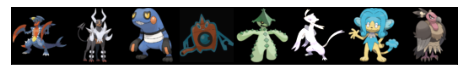

In [ ]:
show_batch(dataloader)

Now that we know the visualization works, we can continue with making the GAN. First, we'll start with the discriminator

In [ ]:
import torch.nn as nn

# Discriminator

In [ ]:
disc = nn.Sequential(
    # Input is 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 16 x 16
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 8 x 8
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

# Generator


In [ ]:
seed_size = 16

In [ ]:
gen = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 128, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 256 x 4 x 4
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 8 x 8
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 64 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 32 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 64 x 64
)

# GPU Setup
We should train this on a GPU, so I'll set that up right now

In [ ]:
def get_training_device():
    # Use the GPU if possible
    if torch.cuda.is_available():
        return torch.device('cuda')
    # Otherwise use the CPU :-(
    return torch.device('cpu')

def to_device(data, device):
    # This moves the tensors to the device (GPU, CPU)
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [ ]:
device = get_training_device()
device

device(type='cuda')

If the above output doesn't say something about 'cuda', then make sure the notebook is set up to run on the GPU accelerator.  

Now, we use the device dataloader class to send data to our chosen device:

In [ ]:
# Using the dataloader from the top of the notebook, and the selected device
# create a device data loader
dev_dataloader = DeviceDataLoader(dataloader, device)

# **Training Functions**

## Discriminator

In [ ]:
def train_discriminator(real_pokemon, disc_optimizer):
    # Reset the gradients for the optimizer
    disc_optimizer.zero_grad()
    
    # Train on the real images
    real_predictions = discriminator(real_pokemon)
    # real_targets = torch.zeros(real_pokemon.size(0), 1, device=device) # All of these are real, so the target is 0.
    real_targets = torch.rand(real_pokemon.size(0), 1, device=device) * (0.1 - 0) + 0 # Add some noisy labels to make the discriminator think harder.
    real_loss = F.binary_cross_entropy(real_predictions, real_targets) # Can do binary loss function because it is a binary classifier
    real_score = torch.mean(real_predictions).item() # How well does the discriminator classify the real pokemon? (Higher score is better for the discriminator)
    
    # Make some latent tensors to seed the generator
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    
    # Get some fake pokemon
    fake_pokemon = generator(latent_batch)
    
    # Train on the generator's current efforts to trick the discriminator
    gen_predictions = discriminator(fake_pokemon)
    # gen_targets = torch.ones(fake_pokemon.size(0), 1, device=device)
    gen_targets = torch.rand(fake_pokemon.size(0), 1, device=device) * (1 - 0.9) + 0.9 # Add some noisy labels to make the discriminator think harder.
    gen_loss = F.binary_cross_entropy(gen_predictions, gen_targets)
    gen_score = torch.mean(gen_predictions).item() # How well did the discriminator classify the fake pokemon? (Lower score is better for the discriminator)
    
    # Update the discriminator weights
    total_loss = real_loss + gen_loss
    total_loss.backward()
    disc_optimizer.step()
    return total_loss.item(), real_score, gen_score

## Generator

In [ ]:
def train_generator(gen_optimizer):
    # Clear the generator gradients
    gen_optimizer.zero_grad()
    
    # Generate some fake pokemon
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    fake_pokemon = generator(latent_batch)
    
    # Test against the discriminator
    disc_predictions = discriminator(fake_pokemon)
    targets = torch.zeros(fake_pokemon.size(0), 1, device=device) # We want the discriminator to think these images are real.
    loss = F.binary_cross_entropy(disc_predictions, targets) # How well did the generator do? (How much did the discriminator believe the generator?)
    
    # Update the generator based on how well it fooled the discriminator
    loss.backward()
    gen_optimizer.step()
    
    # Return generator loss
    return loss.item()

## Results Viewer
We want to be able to see the results as we generate pokemon

In [ ]:
import os
from torchvision.utils import save_image

RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:
def save_results(index, latent_batch, show=True):
    # Generate fake pokemon
    fake_pokemon = generator(latent_batch)
    
    # Make the filename for the output
    fake_file = "result-image-{0:0=4d}.png".format(index)
    
    # Save the image
    save_image(denorm(fake_pokemon), os.path.join(RESULTS_DIR, fake_file), nrow=8)
    print("Result Saved!")
    
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_pokemon.cpu().detach(), nrow=8).permute(1, 2, 0))

# **Full Training**

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

# Static generation seed batch
fixed_latent_batch = torch.randn(64, seed_size, 1, 1, device=device)

def train(epochs, learning_rate, start_idx=1):
    # Empty the GPU cache to save some memory
    torch.cuda.empty_cache()
    
    # Track losses and scores
    disc_losses = []
    disc_scores = []
    gen_losses = []
    gen_scores = []
    
    # Create the optimizers
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    
    # Run the loop
    for epoch in range(epochs):
        # Go through each image
        for real_img, _ in tqdm(dev_dataloader):
            # Train the discriminator
            disc_loss, real_score, gen_score = train_discriminator(real_img, disc_optimizer)

            # Train the generator
            gen_loss = train_generator(gen_optimizer)
        
        # Collect results
        disc_losses.append(disc_loss)
        disc_scores.append(real_score)
        gen_losses.append(gen_loss)
        gen_scores.append(gen_score)
        
        # Print the losses and scores
        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            epoch+start_idx, epochs, gen_loss, disc_loss, real_score, gen_score))
        
        # Save the images and show the progress
        save_results(epoch + start_idx, fixed_latent_batch, show=False)
    
    # Return stats
    return disc_losses, disc_scores, gen_losses, gen_scores

In [ ]:

discriminator = disc
generator = gen
# Send to device
generator = to_device(generator, device)
discriminator = to_device(discriminator, device)

# Training Time


In [ ]:
# learning_rate = 0.0025 # worked fairly well for disc/gen_64_1
learning_rate = 0.00275
epochs = 50

In [ ]:
history = train(epochs, learning_rate)


Epoch [1/50], gen_loss: 0.2398, disc_loss: 1.7215, real_score: 0.7439, gen_score: 0.7298
Result Saved!



Epoch [2/50], gen_loss: 0.6742, disc_loss: 1.1346, real_score: 0.4877, gen_score: 0.6836
Result Saved!



Epoch [3/50], gen_loss: 3.4980, disc_loss: 0.8344, real_score: 0.1187, gen_score: 0.6132
Result Saved!



Epoch [4/50], gen_loss: 1.0436, disc_loss: 1.6191, real_score: 0.6809, gen_score: 0.6668
Result Saved!



Epoch [5/50], gen_loss: 2.2868, disc_loss: 0.5778, real_score: 0.2490, gen_score: 0.8381
Result Saved!



Epoch [6/50], gen_loss: 5.0414, disc_loss: 0.7958, real_score: 0.0075, gen_score: 0.7052
Result Saved!



Epoch [7/50], gen_loss: 0.3920, disc_loss: 2.0794, real_score: 0.8046, gen_score: 0.8423
Result Saved!



Epoch [8/50], gen_loss: 0.2931, disc_loss: 2.5263, real_score: 0.8567, gen_score: 0.5983
Result Saved!



Epoch [9/50], gen_loss: 1.7842, disc_loss: 1.2244, real_score: 0.5811, gen_score: 0.9873
Result Saved!



Epoch [10/50], gen_loss: 1.9701, disc_loss: 0.4683, real_score: 0.0476, gen_score: 0.7683
Result Saved!



Epoch [11/50], gen_loss: 2.4222, disc_loss: 0.7811, real_score: 0.3284, gen_score: 0.7888
Result Saved!



Epoch [12/50], gen_loss: 2.4316, disc_loss: 0.5225, real_score: 0.1553, gen_score: 0.9295
Result Saved!



Epoch [13/50], gen_loss: 4.6693, disc_loss: 0.5682, real_score: 0.1311, gen_score: 0.9886
Result Saved!



Epoch [14/50], gen_loss: 2.5424, disc_loss: 2.1395, real_score: 0.8189, gen_score: 0.9277
Result Saved!



Epoch [15/50], gen_loss: 2.6475, disc_loss: 0.8460, real_score: 0.4511, gen_score: 0.9197
Result Saved!



Epoch [16/50], gen_loss: 3.2137, disc_loss: 0.4937, real_score: 0.1032, gen_score: 0.9067
Result Saved!



Epoch [17/50], gen_loss: 3.1004, disc_loss: 0.4724, real_score: 0.1086, gen_score: 0.8672
Result Saved!



Epoch [18/50], gen_loss: 3.4298, disc_loss: 0.7802, real_score: 0.1029, gen_score: 0.7004
Result Saved!



Epoch [19/50], gen_loss: 1.6978, disc_loss: 0.4254, real_score: 0.1441, gen_score: 0.9658
Result Saved!



Epoch [20/50], gen_loss: 1.7671, disc_loss: 1.2401, real_score: 0.6304, gen_score: 0.9646
Result Saved!



Epoch [21/50], gen_loss: 1.5028, disc_loss: 0.8340, real_score: 0.2029, gen_score: 0.6777
Result Saved!



Epoch [22/50], gen_loss: 2.4205, disc_loss: 0.6968, real_score: 0.2475, gen_score: 0.7651
Result Saved!



Epoch [23/50], gen_loss: 3.2268, disc_loss: 0.8668, real_score: 0.3190, gen_score: 0.7069
Result Saved!



Epoch [24/50], gen_loss: 1.1624, disc_loss: 1.3267, real_score: 0.6057, gen_score: 0.9698
Result Saved!



Epoch [25/50], gen_loss: 2.3487, disc_loss: 0.7943, real_score: 0.4086, gen_score: 0.8585
Result Saved!



Epoch [26/50], gen_loss: 2.3918, disc_loss: 0.9986, real_score: 0.5652, gen_score: 0.9714
Result Saved!



Epoch [27/50], gen_loss: 1.5813, disc_loss: 1.1831, real_score: 0.5392, gen_score: 0.8698
Result Saved!



Epoch [28/50], gen_loss: 3.4719, disc_loss: 1.2785, real_score: 0.1458, gen_score: 0.4051
Result Saved!



Epoch [29/50], gen_loss: 3.0101, disc_loss: 0.4846, real_score: 0.0969, gen_score: 0.9424
Result Saved!



Epoch [30/50], gen_loss: 2.8807, disc_loss: 0.6705, real_score: 0.1760, gen_score: 0.9642
Result Saved!



Epoch [31/50], gen_loss: 3.4547, disc_loss: 0.4809, real_score: 0.0842, gen_score: 0.9197
Result Saved!



Epoch [32/50], gen_loss: 3.6436, disc_loss: 0.5294, real_score: 0.0328, gen_score: 0.8755
Result Saved!



Epoch [33/50], gen_loss: 3.1411, disc_loss: 0.7386, real_score: 0.0030, gen_score: 0.6956
Result Saved!



Epoch [34/50], gen_loss: 2.8499, disc_loss: 0.3824, real_score: 0.0541, gen_score: 0.9217
Result Saved!



Epoch [35/50], gen_loss: 5.2738, disc_loss: 0.4979, real_score: 0.0045, gen_score: 0.9066
Result Saved!



Epoch [36/50], gen_loss: 3.4705, disc_loss: 0.6243, real_score: 0.0585, gen_score: 0.8200
Result Saved!



Epoch [37/50], gen_loss: 5.3991, disc_loss: 0.6654, real_score: 0.0457, gen_score: 0.7597
Result Saved!



Epoch [38/50], gen_loss: 3.4812, disc_loss: 1.1569, real_score: 0.4903, gen_score: 0.9783
Result Saved!



Epoch [39/50], gen_loss: 2.3899, disc_loss: 0.6001, real_score: 0.0262, gen_score: 0.6683
Result Saved!



Epoch [40/50], gen_loss: 2.8957, disc_loss: 0.4044, real_score: 0.0410, gen_score: 0.8488
Result Saved!



Epoch [41/50], gen_loss: 3.0822, disc_loss: 0.5972, real_score: 0.0045, gen_score: 0.8761
Result Saved!



Epoch [42/50], gen_loss: 2.3120, disc_loss: 0.8579, real_score: 0.4231, gen_score: 0.9564
Result Saved!



Epoch [43/50], gen_loss: 4.8255, disc_loss: 0.4126, real_score: 0.0557, gen_score: 0.9469
Result Saved!



Epoch [44/50], gen_loss: 3.4864, disc_loss: 0.4443, real_score: 0.0786, gen_score: 0.9493
Result Saved!



Epoch [45/50], gen_loss: 2.4480, disc_loss: 0.4181, real_score: 0.1102, gen_score: 0.9389
Result Saved!



Epoch [46/50], gen_loss: 4.0184, disc_loss: 0.3493, real_score: 0.0346, gen_score: 0.9494
Result Saved!



Epoch [47/50], gen_loss: 3.8925, disc_loss: 0.5187, real_score: 0.0859, gen_score: 0.8976
Result Saved!



Epoch [48/50], gen_loss: 1.6897, disc_loss: 0.4657, real_score: 0.0137, gen_score: 0.9044
Result Saved!



Epoch [49/50], gen_loss: 3.8152, disc_loss: 0.5453, real_score: 0.1467, gen_score: 0.9863
Result Saved!



Epoch [50/50], gen_loss: 3.3381, disc_loss: 0.5022, real_score: 0.0934, gen_score: 0.7889
Result Saved!


# View Results
Here, we will view the results for the PokeGAN using IPython's Image class

In [ ]:
from IPython.display import Image

There are some blobs appearing at 10 epochs

At 25 epochs the fake pokemon have more defined shapes:

And by 50 epochs, more distinct features start appearing:

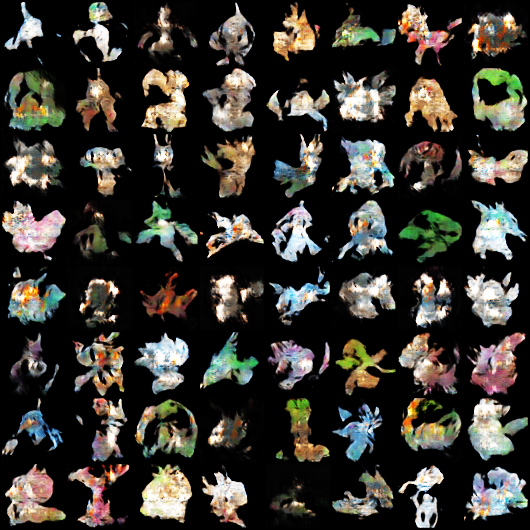

In [ ]:
Image('result-image-0050.png')

# Performance Analysis

Here are some plots to help tune the generator/discriminator. This shows losses and scores over time.

In [ ]:
# Extract metrics
disc_losses, disc_scores, gen_losses, gen_scores = history

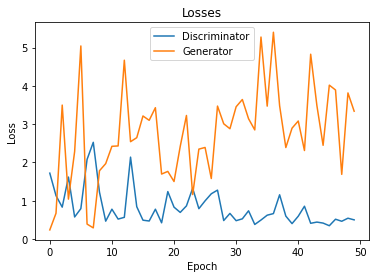

In [ ]:
# Plot generator and discriminator losses
plt.plot(disc_losses, '-')
plt.plot(gen_losses, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

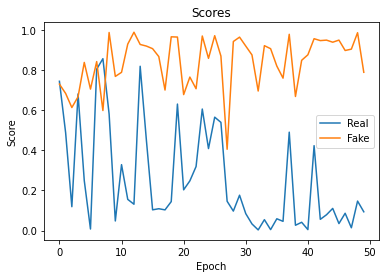

In [ ]:
# Plots scores vs. epochs
plt.plot(disc_scores, '-')
plt.plot(gen_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

# Exporting Data
If the model works well, it definitely should be saved for later! Here I will export the weights for both the discriminator and generator, as well as send the notebook to Jovian.ml

In [ ]:
# Save generator and discriminator weights
torch.save(discriminator.state_dict(), 'model/discriminator-model.pth')
torch.save(generator.state_dict(), 'model/generator-model.pth')